In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import pickle


In [13]:
import pandas as pd

# Define proper column names manually (based on the dataset structure)
column_names = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 
                'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region']

# Load the dataset with no header row in CSV
df_raw = pd.read_csv("Algerian_forest_fires_cleaned.csv", header=None, names=column_names)

# Drop repeated headers (in case regions were merged with headers in between)
df_raw = df_raw[df_raw['Temperature'] != 'Temperature']  # remove header duplicates

# Convert all numeric columns
for col in df_raw.columns:
    if col not in ['Classes', 'Region']:
        try:
            df_raw[col] = pd.to_numeric(df_raw[col])
        except:
            pass

# Create a datetime column from day/month/year
df_raw['Date'] = pd.to_datetime(df_raw[['day', 'month', 'year']])

# Drop original day/month/year
df_raw.drop(['day', 'month', 'year'], axis=1, inplace=True)

# Drop Region column if not needed
df_raw.drop(['Region'], axis=1, inplace=True)

# Drop rows with missing values
df_raw.dropna(inplace=True)

# Reset index
df_raw.reset_index(drop=True, inplace=True)

# Preview
df_raw.head()


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Date
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,2012-06-01
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,2012-06-02
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,2012-06-03
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,2012-06-04
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,2012-06-05


In [21]:
df_raw['Classes'] = df_raw['Classes'].map({'not_fire': 0, 'fire': 1})
df_raw['Classes'].value_counts()

Classes
1.0    4
Name: count, dtype: int64

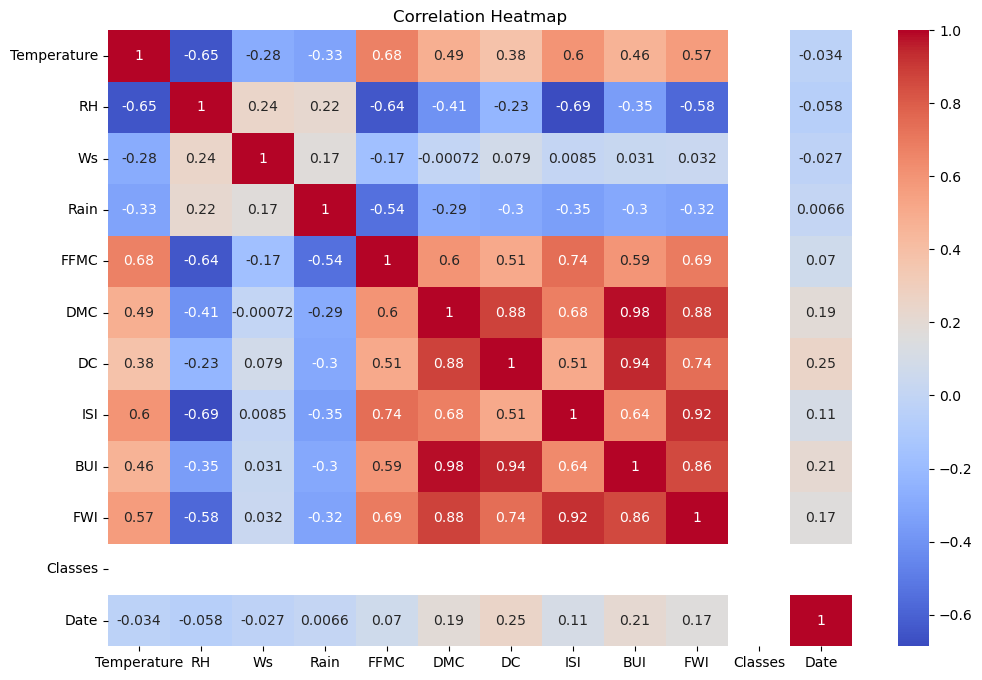

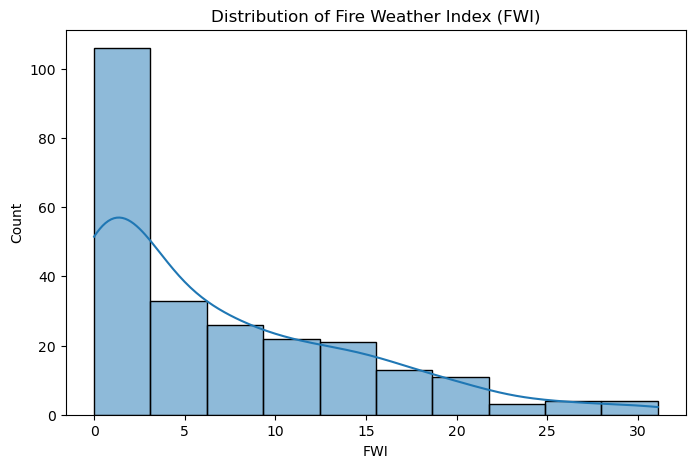

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_raw.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_raw['FWI'], kde=True)
plt.title("Distribution of Fire Weather Index (FWI)")
plt.show()


In [25]:
# Define features and target
X = df_raw.drop('FWI', axis=1)
y = df_raw['FWI']

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [49]:
if 'Date' in X_train.columns:
    X_train = X_train.drop('Date', axis=1)
if 'Date' in X_test.columns:
    X_test = X_test.drop('Date', axis=1)


In [51]:
# Initialize the imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit imputer on training data and transform both training and test sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [53]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)


Lasso()

In [59]:

# Save the trained model to a file
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [61]:
# Load the model from the file
with open('linear_regression_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use the loaded model to predict
y_pred = loaded_model.predict(X_test_scaled)

In [63]:
# Predict using each model
y_pred_lr = lr.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)
y_pred_lasso = lasso.predict(X_test_scaled)

# Print metrics
print("Linear Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("R2:", r2_score(y_test, y_pred_lr))

print("\nRidge Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R2:", r2_score(y_test, y_pred_ridge))

print("\nLasso Regression:")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R2:", r2_score(y_test, y_pred_lasso))


Linear Regression:
MSE: 127.0024405657989
R2: nan

Ridge Regression:
MSE: 190.6044973238708
R2: nan

Lasso Regression:
MSE: 59.42709322386028
R2: nan


C:\Users\bhava\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\bhava\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\bhava\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
